# Simulation of Magnetic Field Effects
- Jeff

Thinking about how to use B field around science cell to detune atoms in tweezers from scattering light from MOT


## MOT Scattering
We want to calculate, in order
1. The scattering rate off of the MOT


2. The intensity of scattered MOT light
3. The intensity of scattered MOT light that reaches the atoms in tweezers
4. The detuning between lightshifted atoms in tweezers + scattered MOT light (gnd state)
5. The scattering rate of the tweezered atoms as a result of MOT light

In [3]:
### Useful functions
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import arc
from get_polarizability import *

# constants
h = 6.62607015e-34  # Planck's constant in J*s
hbar = h / (2 * np.pi)  # reduced Planck's constant
c = 299792458  # speed of light in m/s
epsilon_0 = 8.854187817e-12  # vacuum permittivity in F/m
a0 = 5.29177210903e-11  # Bohr radius in meters
e = 1.602176634e-19  # elementary charge in Coulombs
me = 9.10938356e-31  # electron mass in kg
kB = 1.380649e-23  # Boltzmann constant in J/K

# Cs information
Cs_D1_wavelength = 894.592959e-9  # Cs D1 line wavelength in meters
Cs_D1_frequency = c / Cs_D1_wavelength  # Cs D1 line frequency in Hz
Cs_D1_gamma = 4.5612e6 # Cs D1 line natural linewidth in Hz
Cs_D1_pi_Isat = 2.4981*10  # Cs D1 line pi-polarized saturation intensity in W/m^2

Cs_D2_wavelength = 852.34727582e-9  # Cs D2 line wavelength in meters
Cs_D2_frequency = c / Cs_D2_wavelength  # Cs D2 line frequency in Hz
Cs_D2_gamma = 5.2227e6 # Cs D2 line natural linewidth in Hz
Cs_D2_pi_Isat = 1.6536*10  # Cs D2 line pi-polarized saturation intensity in W/m^2
Cs_D2_iso_Isat = 2.7059*10  # Cs D2 line isotropic saturation intensity in W/m^2
Cs_D2_sigma_Isat = 1.1023*10  # Cs D2 line sigma-polarized saturation intensity in W/m^2

# Rb information
Rb_D1_wavelength = 794.978850e-9      # Rb D1 line wavelength in meters
Rb_D1_frequency = c / Rb_D1_wavelength  # Rb D1 line frequency in Hz
Rb_D1_gamma = 5.746e6 # Rb D1 line natural linewidth in Hz
Rb_D1_pi_Isat = 4.484*10  # Rb D1 line pi-polarized saturation intensity in W/m^2

Rb_D2_wavelength = 780.241209686e-9  # Rb D2 line wavelength in meters
Rb_D2_frequency = c / Rb_D2_wavelength  # Rb D2 line frequency in Hz
Rb_D2_gamma = 6.065e6 # Rb D2 line natural linewidth in Hz
Rb_D2_pi_Isat = 2.503*10  # Rb D2 line pi-polarized saturation intensity in W/m^2
Rb_D2_iso_Isat = 3.576*10  # Rb D2 line isotropic saturation intensity in W/m^2
Rb_D2_sigma_Isat = 1.669*10  # Rb D2 line sigma-polarized saturation intensity in W/m^2

In [4]:
def calc_scattering_rate(I, I_sat, delta, gamma):
    """
    Calculate the scattering rate of an atom given the laser intensity,
    saturation intensity, detuning, and natural linewidth.

    Parameters:
    I (float): Laser intensity
    I_sat (float): Saturation intensity
    delta (float): Detuning from resonance (in Hz)
    gamma (float): Natural linewidth of the transition (in Hz)

    Returns:
    float: Scattering rate (in Hz)
    """
    s = I / I_sat  # Saturation parameter
    scattering_rate = np.pi * gamma * (s / (1 + s + (2 * delta / gamma) ** 2)) # from Amanda's code - ist this correct? - yes
    # scattering_rate = (gamma / 2) * (s / (1 + s + (2 * delta / (gamma/(2*np.pi))) ** 2))
    return scattering_rate

def intensity_from_rate(Rsc, distance, frequency):
    # Each photon has energy hv, so power = Rsc * hv
    power = Rsc * h * frequency
    return power/(4*np.pi*(distance**2))

def interaction_cross_section(I, I_sat, delta, gamma, wavelength):
    sigma_0 = 3*wavelength**2/(2*np.pi)
    return sigma_0 / (1 + ((2*delta/gamma)**2) + I/I_sat)

In [127]:
# Rb Experiment parameters (D2 line)
Rb_MOT_detuning = 17e6 # Hz, from Atom Array 2
Rb_MOT_intensity = 0.01/(4*np.pi*(0.1e-3)**2) # W/m^2, from Atom Array 2 assuming 0.2 mm MOT diameter
Rb_MOT_temperature = 50e-6 # uK
transport_distance = 30e-2 # m
aperature_radius = 1e-2 # m
Rb_tweezer_depth = 0.8 #mK
Rb_tweezer_wavelength = 809e-9
Rb_tweezer_frequency = c/Rb_tweezer_wavelength #809 nm tweezers
Rb_tweezer_intensity = 6e-3/(4*np.pi*(0.5e-6)**2) # W/m^2, 6mW per beam, 0.5 um waist

In [128]:
Rb_MOT_frequency = Rb_D2_frequency - Rb_MOT_detuning
Rb_R_MOT = calc_scattering_rate(Rb_MOT_intensity, Rb_D2_pi_Isat, Rb_MOT_detuning, Rb_D2_gamma)
Rb_I_MOT = intensity_from_rate(Rb_R_MOT, transport_distance, Rb_MOT_frequency)
Rb_I_at_atoms = Rb_I_MOT * (aperature_radius**2)/(transport_distance**2) #assume aperature << SA of emission at transport distance
pol_conversion = 4*np.pi*epsilon_0*(a0**3)
Rb_Ufe = (-1*get_polarizability(Rb_tweezer_wavelength, atom="Rb", orbital="5p3")* pol_conversion/(2*c*epsilon_0))*Rb_tweezer_intensity
Rb_Ufg = (-1*get_polarizability(Rb_tweezer_wavelength, atom="Rb", orbital="5s")* pol_conversion/(2*c*epsilon_0))*Rb_tweezer_intensity
Rb_D2freq_shift = (Rb_Ufe-Rb_Ufg)/h #shift of D2 line in tweezers
Rb_D2freq_in_tweezer = Rb_D2_frequency+Rb_D2freq_shift
Rb_R_D2_tweezer = calc_scattering_rate(Rb_I_at_atoms, Rb_D2_pi_Isat, Rb_MOT_frequency-Rb_D2freq_in_tweezer, Rb_D2_gamma)
Rb_xc_tweezer = interaction_cross_section(Rb_I_at_atoms, Rb_D2_pi_Isat, Rb_MOT_frequency-Rb_D2freq_in_tweezer, Rb_D2_gamma, c/Rb_MOT_frequency)
Rb_flux_tweezer = Rb_R_D2_tweezer/Rb_xc_tweezer
print(f"Rb87 scattering rate off MOT (photons/s): {Rb_R_MOT}")
print(f"Rb87 D2 detuning in tweezers (Hz): {Rb_D2freq_shift}")
print(f"Rb87 scattering rate in tweezers off D2 line (photons/s): {Rb_R_D2_tweezer}")
print(f"Rb87 flux through atom cross section (photons/s*interaction xc): {Rb_flux_tweezer}")
print(f"Rb87 avg time before 1 MOT photon bothers tweezer atom (s): {1/Rb_flux_tweezer}")

Rb87 scattering rate off MOT (photons/s): 18861386.23112317
Rb87 D2 detuning in tweezers (Hz): -3368901.3439596226
Rb87 scattering rate in tweezers off D2 line (photons/s): 1.6935846863492486e-10
Rb87 flux through atom cross section (photons/s*interaction xc): 12355.12627607395
Rb87 avg time before 1 MOT photon bothers tweezer atom (s): 8.093806389794073e-05


In [129]:
# Cs Experiment parameters (D2 line)
Cs_MOT_detuning = 1e6 # Assume 1GHz
Cs_MOT_intensity = (0.5e-3)/(4*np.pi*(0.1e-3)**2) # W/m^2, from Yichao's thesis assuming 0.2 mm MOT diameter
Cs_MOT_temperature = 50e-6 # uK
transport_distance = 30e-2 # m
aperature_radius = 1e-2 # m
Cs_tweezer_depth = 0.8 #mK
Cs_tweezer_wavelength = 1064e-9
Cs_tweezer_frequency = c/Cs_tweezer_wavelength #1064 nm tweezers
Cs_tweezer_intensity = 46e-3/(4*np.pi*(0.5e-6)**2) # W/m^2, 46mW per beam, 0.5 um waist

In [130]:
Cs_MOT_frequency = Cs_D2_frequency - Cs_MOT_detuning
Cs_R_MOT = calc_scattering_rate(Cs_MOT_intensity, Cs_D2_pi_Isat, Cs_MOT_detuning, Cs_D2_gamma)
Cs_I_MOT = intensity_from_rate(Cs_R_MOT, transport_distance, Cs_MOT_frequency)
Cs_I_at_atoms = Cs_I_MOT * (aperature_radius**2)/(transport_distance**2) #assume aperature << SA of emission at transport distance
pol_conversion = 4*np.pi*epsilon_0*(a0**3)
Cs_Ufe = (-1*get_polarizability(Cs_tweezer_wavelength, atom="Cs", orbital="6p3")* pol_conversion/(2*c*epsilon_0))*Cs_tweezer_intensity
Cs_Ufg = (-1*get_polarizability(Cs_tweezer_wavelength, atom="Cs", orbital="6s")* pol_conversion/(2*c*epsilon_0))*Cs_tweezer_intensity
Cs_D2freq_shift = (Cs_Ufe-Cs_Ufg)/h #shift of D2 line in tweezers
Cs_D2freq_in_tweezer = Cs_D2_frequency+Cs_D2freq_shift
Cs_R_D2_tweezer = calc_scattering_rate(Cs_I_at_atoms, Cs_D2_pi_Isat, Cs_MOT_frequency-Cs_D2freq_in_tweezer, Cs_D2_gamma)
Cs_xc_tweezer = interaction_cross_section(Cs_I_at_atoms, Cs_D2_pi_Isat, Cs_MOT_frequency-Cs_D2freq_in_tweezer, Cs_D2_gamma, c/Cs_MOT_frequency)
Cs_flux_tweezer = Cs_R_D2_tweezer/Cs_xc_tweezer
print(f"Cs scattering rate off MOT (photons/s): {Cs_R_MOT}")
print(f"Cs D2 detuning in tweezers (Hz): {Cs_D2freq_shift}")
print(f"Cs scattering rate in tweezers off D2 line (photons/s): {Cs_R_D2_tweezer}")
print(f"Cs flux through atom cross section (photons/s*interaction xc): {Cs_flux_tweezer}")
print(f"Cs avg time before 1 MOT photon bothers tweezer atom (s): {1/Cs_flux_tweezer}")


Cs scattering rate off MOT (photons/s): 16329777.978949651
Cs D2 detuning in tweezers (Hz): -15808252.21701667
Cs scattering rate in tweezers off D2 line (photons/s): 1.1188785773593679e-10
Cs flux through atom cross section (photons/s*interaction xc): 10695.115923208901
Cs avg time before 1 MOT photon bothers tweezer atom (s): 9.350062282447573e-05


## Magnetic field affects
1. How much B do we need to light shift the Cs/Rb D2 line in tweezers more than one linewidth away from the MOT light?
2. How much B do we need to get the Cs/Rb flux to be negligable?

The first four cells are just replicating the data from the steck datasheets
- Rb: https://steck.us/alkalidata/rubidium87numbers.1.6.pdf
- Cs: https://steck.us/alkalidata/cesiumnumbers.1.6.pdf


In [ ]:
# Physical constants (CODATA-ish values)
mu_B = 9.2740100783e-24       # J/T (Bohr magneton)
mu_N = 5.0507837461e-27       # J/T (nuclear magneton)
h = 6.62607015e-34            # J*s (Planck constant)
mu_B_over_h = mu_B / h        # Hz / T
mu_N_over_h = mu_N / h        # Hz / T


def ang_matrices(j):
    """Return angular momentum matrices (Jx, Jy, Jz) for a spin-j system (dimension 2j+1)."""
    dim = int(2*j + 1)
    m = np.arange(j, -j-1, -1)
    Jz = np.diag(m)
    Jp = np.zeros((dim, dim), dtype=complex)
    for i in range(dim-1):
        m_val = j - i
        coeff = np.sqrt((j - (m_val-1))*(j + (m_val)))
        Jp[i, i+1] = coeff
    Jm = Jp.T.conj()
    Jx = 0.5 * (Jp + Jm)
    Jy = -0.5j * (Jp - Jm)
    return Jx, Jy, Jz

def kron(a, b):
    return np.kron(a, b)

def build_hamiltonian(I, J, A_hz=0.0, B_hz=0.0, gJ=0.0, gI=0.0, B_field=0.0):
    """
    Build the full Hamiltonian (in Hz) for hyperfine + quadrupole (optional) + Zeeman terms
    in the uncoupled |mI, mJ> basis.

    Returns:
        H_total (ndarray) : Hamiltonian in Hz
        basis_states (list) : [(mI, mJ), ...] in the ordering used
        Fz_op (ndarray) : operator (Iz + Jz) in this basis (dimensionless, eigenvalues mF)
    """
    # Build angular momentum matrices for I and J
    Ix, Iy, Iz = ang_matrices(I)
    Jx, Jy, Jz = ang_matrices(J)
    dimI = Ix.shape[0]
    dimJ = Jx.shape[0]

    # Tensor-space operators
    Iop_dot_Jop = kron(Ix, Jx) + kron(Iy, Jy) + kron(Iz, Jz)   # I·J
    Iz_op = kron(Iz, np.eye(dimJ))
    Jz_op = kron(np.eye(dimI), Jz)
    Fz_op = Iz_op + Jz_op  # (dimensionless) eigenvalues are mF

    # Hyperfine term
    H_hf = A_hz * Iop_dot_Jop

    # Quadrupole term (optional)
    H_q = np.zeros_like(H_hf, dtype=complex)
    if B_hz != 0.0:
        denom = 2.0 * I * (2.0*I - 1.0) * J * (2.0*J - 1.0)
        if abs(denom) < 1e-12:
            raise ValueError("Quadrupole term undefined for given I or J (denominator zero).")
        T = (3.0 * (Iop_dot_Jop @ Iop_dot_Jop)
             + 1.5 * Iop_dot_Jop
             - (I*(I+1.0))*(J*(J+1.0)) * np.eye(Iop_dot_Jop.shape[0]))
        H_q = B_hz * (T / denom)

    # Zeeman term (B along z)
    H_zeeman = B_field * (mu_B_over_h * gJ * Jz_op + mu_N_over_h * gI * Iz_op)

    H_total = H_hf + H_q + H_zeeman

    # Basis ordering: mI runs I..-I, then mJ runs J..-J
    mI_vals = np.arange(I, -I-1, -1)
    mJ_vals = np.arange(J, -J-1, -1)
    basis_states = [(float(mI), float(mJ)) for mI in mI_vals for mJ in mJ_vals]

    return H_total, basis_states, Fz_op

def _snap_half_integer(x, tol=1e-8):
    """
    Snap a float to the nearest half-integer (…, -1.5, -1.0, -0.5, 0, 0.5, …)
    """
    return 0.5 * np.round(2.0 * x)

def diagonalize_levels_by_mF(I, J, A_hz=0.0, B_hz=0.0, gJ=0.0, gI=0.0, B_fields=None,
                             tol_mF=1e-6):
    """
    Diagonalize H over B_fields and return energies grouped by mF only.

    Returns:
        B_fields (ndarray) : shape (nB,)
        energies_by_mF (dict) : mF -> ndarray shape (nB, n_states_in_that_mF_block)
        basis (list) : |mI, mJ> basis ordering
        mF_list (list) : sorted list of mF keys
    """
    if B_fields is None:
        B_fields = np.linspace(0, 1, 101)

    # Determine allowed mF values from the uncoupled basis once
    # (works because mF = mI + mJ in the basis)
    H0, basis, Fz0 = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=B_fields[0])
    mF_basis = np.array([mI + mJ for (mI, mJ) in basis], dtype=float)
    mF_keys = sorted(set(_snap_half_integer(mF_basis)))

    # We’ll accumulate lists then stack into arrays
    energies_by_mF = {mF: [] for mF in mF_keys}

    for B in B_fields:
        H, _, Fz_op = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=B)

        # Need eigenvectors to label by mF
        vals, vecs = la.eigh(H)  # Hermitian => real vals, orthonormal vecs

        # Compute <Fz> for each eigenvector
        # vecs columns are eigenvectors
        Fz_vecs = Fz_op @ vecs
        mF_expect = np.einsum('ij,ij->j', np.conjugate(vecs), Fz_vecs).real  # length dim

        # Snap to nearest half-integer (robust to tiny numeric noise)
        mF_labels = _snap_half_integer(mF_expect)

        # Sanity: in weak/intermediate regime with B along z, states should be pure mF blocks
        # (i.e., <Fz> should be extremely close to a half-integer)
        if np.max(np.abs(mF_expect - mF_labels)) > tol_mF:
            raise RuntimeError(
                f"mF labeling error at B={B:.6g} T: max |<Fz>-mF| = "
                f"{np.max(np.abs(mF_expect - mF_labels)):.3e}. "
                "This suggests mF is not conserved (check B direction or Hamiltonian terms)."
            )

        # Group energies by mF; sort within each mF block for consistency
        for mF in mF_keys:
            idx = np.where(mF_labels == mF)[0]
            e_block = np.sort(vals[idx].real)
            energies_by_mF[mF].append(e_block)

    # Stack: each mF gets (nB, nStatesInBlock)
    for mF in mF_keys:
        energies_by_mF[mF] = np.vstack(energies_by_mF[mF])

    return np.array(B_fields, dtype=float), energies_by_mF, basis, mF_keys

def lande_gJ(L, S, J, gL=1.0, gS=2.0023193043737):
    return (gL * (J*(J+1) - S*(S+1) + L*(L+1)) / (2*J*(J+1))
          + gS * (J*(J+1) + S*(S+1) - L*(L+1)) / (2*J*(J+1)))

def spectroscopic_term(L, S, J):
    L_letters = "SPDFGHIKLMNO"
    if L < 0 or L >= len(L_letters):
        raise ValueError("Unsupported L value")
    multiplicity = int(2*S + 1)
    if abs(J - int(J)) < 1e-12:
        J_str = "{"+f"{int(J)}"+"}"
    else:
        J_str = "{"+f"{int(2*J)}/2"+"}"
    return f"^{multiplicity}{L_letters[L]}_{J_str}"

1.5


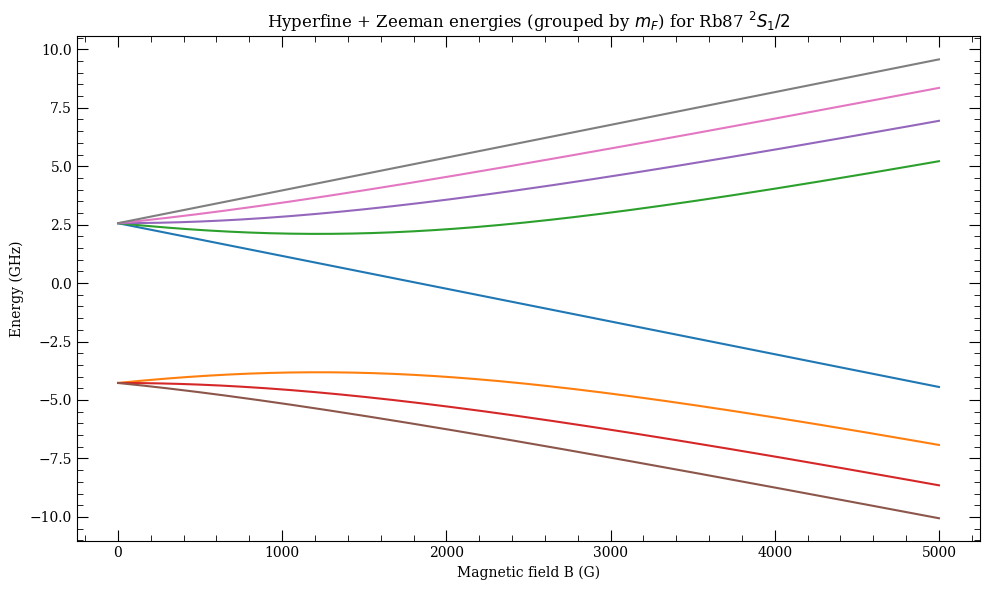

In [16]:
## Rb87 5^2 S_(1/2) ##
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 0
J = 1/2
S = 1/2 # For alkali atoms

# Calculated constants
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
I = atom.I              # nuclear spin
print(I)
A_hz, B_hz = atom.getHFSCoefficients(n=n, l=L, j=J) 

B_fields = np.linspace(0.0001, 0.5, 201)  # in T

# Diagonalize and label by mF
Bs, energies_by_mF, basis, mF_list = diagonalize_levels_by_mF(
    I, J,
    A_hz=A_hz, B_hz=B_hz,
    gJ=gJ, gI=gI,
    B_fields=B_fields
)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10, 6))

# Loop over mF blocks; each block has shape (nB, nStatesInBlock)
for mF in mF_list:
    Eblock = energies_by_mF[mF]  # (len(Bs), n_lines_in_this_mF)
    for k in range(Eblock.shape[1]):
        plt.plot(Bs * 1e4, Eblock[:, k] / 1e9)  # B in Gauss, E in GHz

plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
plt.title(f"Hyperfine + Zeeman energies (grouped by $m_F$) for {atom.elementName} ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()


I = 1.5


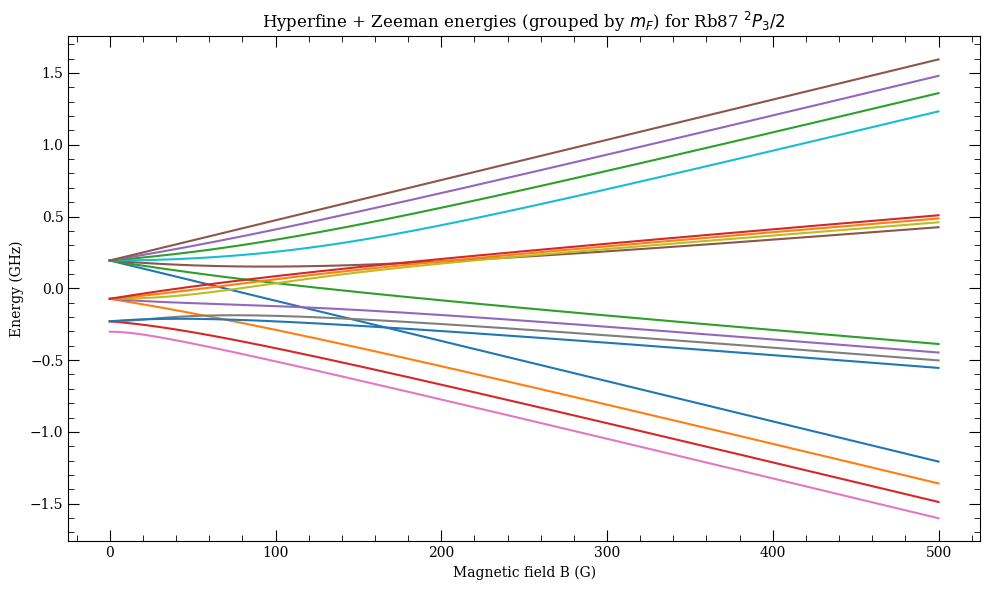

In [17]:
## 5^2 P_(3/2) ##
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 1
J = 3/2
S = 1/2  # For alkali atoms

# Calculated constants
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
I  = atom.I              # nuclear spin

print("I =", I)
A_hz, B_hz = atom.getHFSCoefficients(n=n, l=L, j=J)

B_fields = np.linspace(0.0, 0.05, 201)  # Tesla (0..500 G)

# Diagonalize and label by mF
Bs, energies_by_mF, basis, mF_list = diagonalize_levels_by_mF(
    I, J,
    A_hz=A_hz, B_hz=B_hz,
    gJ=gJ, gI=gI,
    B_fields=B_fields
)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10, 6))

# Loop over mF blocks; each block has shape (nB, nStatesInBlock)
for mF in mF_list:
    Eblock = energies_by_mF[mF]  # (len(Bs), n_lines_in_this_mF)
    for k in range(Eblock.shape[1]):
        plt.plot(Bs * 1e4, Eblock[:, k] / 1e9)  # B in Gauss, E in GHz

plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
plt.title(f"Hyperfine + Zeeman energies (grouped by $m_F$) for {atom.elementName} ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()

1.5


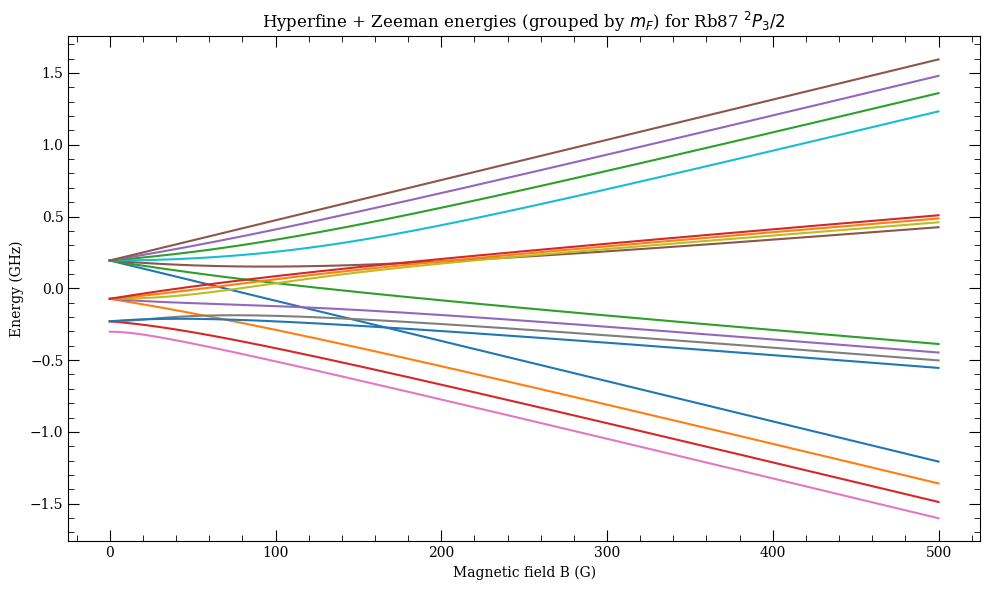

Zero-field eigenvalues (Hz) and mF labels:
E = -3.020738e+08 Hz,   mF = +0
E = -2.298518e+08 Hz,   mF = +0
E = -2.298517e+08 Hz,   mF = +1
E = -2.298517e+08 Hz,   mF = -1
E = -7.291125e+07 Hz,   mF = +0
E = -7.291125e+07 Hz,   mF = -2
E = -7.291125e+07 Hz,   mF = +2
E = -7.291125e+07 Hz,   mF = -1
E = -7.291125e+07 Hz,   mF = +1
E = 1.937407e+08 Hz,   mF = +0
E = 1.937407e+08 Hz,   mF = +2
E = 1.937407e+08 Hz,   mF = -1
E = 1.937407e+08 Hz,   mF = +1
E = 1.937408e+08 Hz,   mF = +3
E = 1.937408e+08 Hz,   mF = -3
E = 1.937408e+08 Hz,   mF = -2

Basis ordering (mI, mJ):
 [(1.5, 1.5), (1.5, 0.5), (1.5, -0.5), (1.5, -1.5), (0.5, 1.5), (0.5, 0.5), (0.5, -0.5), (0.5, -1.5), (-0.5, 1.5), (-0.5, 0.5), (-0.5, -0.5), (-0.5, -1.5), (-1.5, 1.5), (-1.5, 0.5), (-1.5, -0.5), (-1.5, -1.5)]


In [18]:
## 5^2 P_(3/2) ##
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 1
J = 3/2
S = 1/2 # For alkali atoms

# Calculated constants
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
I = atom.I              # nuclear spin
print(I)
A_hz, B_hz = atom.getHFSCoefficients(n=n, l=L, j=J) 

B_fields = np.linspace(0.0, 0.05, 201)  # in T

# Diagonalize and label by mF
Bs, energies_by_mF, basis, mF_list = diagonalize_levels_by_mF(
    I, J,
    A_hz=A_hz, B_hz=B_hz,
    gJ=gJ, gI=gI,
    B_fields=B_fields
)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10, 6))

# Loop over mF blocks; each block has shape (nB, nStatesInBlock)
for mF in mF_list:
    Eblock = energies_by_mF[mF]  # (len(Bs), n_lines_in_this_mF)
    for k in range(Eblock.shape[1]):
        plt.plot(Bs * 1e4, Eblock[:, k] / 1e9)  # B in Gauss, E in GHz

plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
plt.title(f"Hyperfine + Zeeman energies (grouped by $m_F$) for {atom.elementName} ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()

# --- OPTIONAL: print zero-field eigenvalues, plus each state's mF label ---
H0, basis0, Fz0 = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=0.0)
vals0, vecs0 = la.eigh(H0)

# mF expectation values at B=0 (still well-defined; degeneracies may exist)
Fz_vecs0 = Fz0 @ vecs0
mF_expect0 = np.einsum('ij,ij->j', np.conjugate(vecs0), Fz_vecs0).real
mF_labels0 = 0.5 * np.round(2.0 * mF_expect0)

order = np.argsort(vals0.real)

print("Zero-field eigenvalues (Hz) and mF labels:")
for idx in order:
    print(f"E = {vals0[idx].real:.6e} Hz,   mF = {mF_labels0[idx]:+g}")

print("\nBasis ordering (mI, mJ):\n", basis0)

3.5


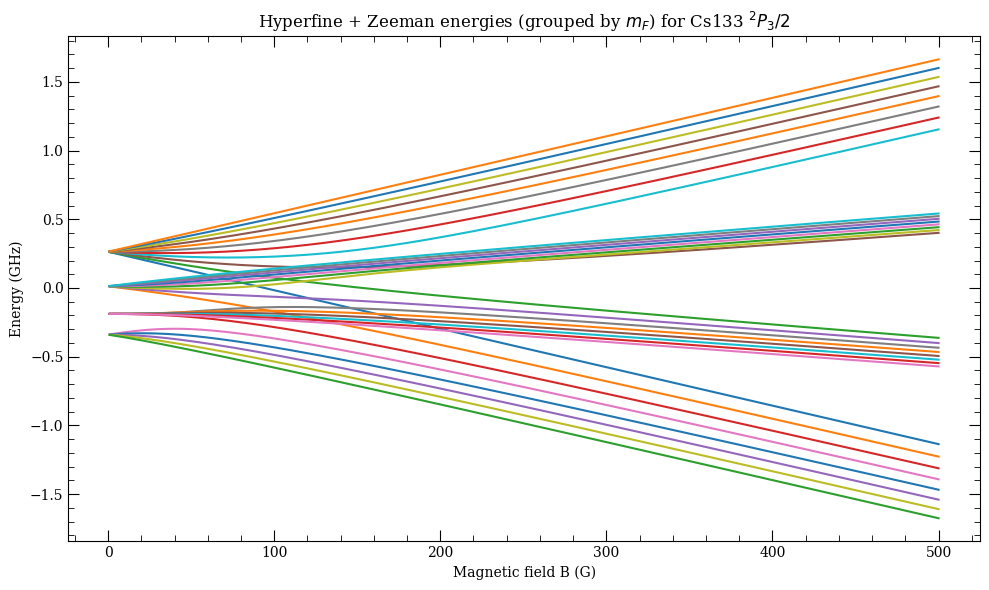

In [ ]:
## 6^2 P_(3/2) ##
atom = arc.Caesium()   # pick an atom
n = 6
L = 1
J = 3/2
S = 1/2 # For alkali atoms

# Calculated constants
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
I = atom.I              # nuclear spin
print(I)
A_hz, B_hz = atom.getHFSCoefficients(n=n, l=L, j=J) 

B_fields = np.linspace(0.0001, 0.05, 201)  # in T

# Diagonalize and label by mF
Bs, energies_by_mF, basis, mF_list = diagonalize_levels_by_mF(
    I, J,
    A_hz=A_hz, B_hz=B_hz,
    gJ=gJ, gI=gI,
    B_fields=B_fields
)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10, 6))

# Loop over mF blocks; each block has shape (nB, nStatesInBlock)
for mF in mF_list:
    Eblock = energies_by_mF[mF]  # (len(Bs), n_lines_in_this_mF)
    for k in range(Eblock.shape[1]):
        plt.plot(Bs * 1e4, Eblock[:, k] / 1e9)  # B in Gauss, E in GHz

plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
plt.title(f"Hyperfine + Zeeman energies (grouped by $m_F$) for {atom.elementName} ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()


In [ ]:
## Finding D2 transition frequencies for Rb87 in B
# we'll need to account for transition rules - so we need to rewrite the diagonalization function to keep track of which manifold stuff belongs to
def zeeman_transition_frequencies_by_mF(
    lower_state, upper_state, B_fields,
    allowed_delta_mF=(0, +1, -1),
    require_B0_in_grid=True,
    tol_mF=1e-6
):
    """
    Compute optical transition frequencies vs B between Zeeman-resolved eigenstates,
    grouped/labeled by mF, enforcing ΔmF = 0, ±1.

    This function assumes you are in weak/intermediate-field regime where mF is conserved
    (B defines quantization axis, Hamiltonian commutes with Fz).

    Parameters
    ----------
    lower_state : dict
        Dict describing lower manifold, must contain:
            I, J, A_hz, B_hz, gJ, gI
        Example:
            lower_state = dict(I=atom.I, J=1/2, A_hz=A1, B_hz=B1, gJ=gJ1, gI=atom.gI)
    upper_state : dict
        Dict describing upper manifold, same keys as lower_state.
    nu0_hz : float
        Bare transition frequency at B=0 (Hz). The function returns
        nu(B) = nu0 + [ (E_u(B)-E_u(0)) - (E_l(B)-E_l(0)) ].
    B_fields : array-like
        Magnetic field grid (Tesla). Strongly recommended to include B=0.
    allowed_delta_mF : tuple
        Which ΔmF transitions to include. Default (0, +1, -1).
        Map to polarization if you want:
            ΔmF=0 -> π
            ΔmF=+1 -> σ+
            ΔmF=-1 -> σ-
    require_B0_in_grid : bool
        If True, raise if B_fields does not contain 0 T (within float tolerance).
        If False, the function will prepend B=0 to the grid internally and compute.
    tol_mF : float
        Passed through to diagonalize_levels_by_mF sanity check.

    Returns
    -------
    Bs : ndarray
        B_fields used (Tesla). If B=0 was prepended, this includes it.
    transitions : dict
        Dictionary mapping string labels -> ndarray of nu(B) in Hz, shape (nB,).

        Label format:
            "mF=+1.5 (i=0) -> mF'=+2.5 (j=1), ΔmF=+1"
        where i/j are branch indices within the fixed-mF blocks (sorted by energy).
    """

    Bs = np.array(B_fields, dtype=float)

    # Diagonalize both manifolds, grouped by mF (each block sorted within mF)
    Bs_l, E_l_by_mF, _, mF_l = diagonalize_levels_by_mF(
        lower_state["I"], lower_state["J"],
        A_hz=lower_state.get("A_hz", 0.0),
        B_hz=lower_state.get("B_hz", 0.0),
        gJ=lower_state.get("gJ", 0.0),
        gI=lower_state.get("gI", 0.0),
        B_fields=Bs,
        tol_mF=tol_mF
    )

    Bs_u, E_u_by_mF, _, mF_u = diagonalize_levels_by_mF(
        upper_state["I"], upper_state["J"],
        A_hz=upper_state.get("A_hz", 0.0),
        B_hz=upper_state.get("B_hz", 0.0),
        gJ=upper_state.get("gJ", 0.0),
        gI=upper_state.get("gI", 0.0),
        B_fields=Bs,
        tol_mF=tol_mF
    )

    # Sanity: both should have identical B grids
    if Bs_l.shape != Bs_u.shape or np.max(np.abs(Bs_l - Bs_u)) > 0:
        raise RuntimeError("Internal error: B grids for lower/upper diagonalizations do not match.")

    Bs = Bs_l

    # Build transition dictionary
    transitions = {}

    # For each allowed ΔmF, connect lower mF -> upper mF'
    for dm in allowed_delta_mF:
        for mF in mF_l:
            mFp = mF + dm
            if mF not in E_l_by_mF:
                continue
            if mFp not in E_u_by_mF:
                continue

            E_l_block = E_l_by_mF[mF]   # (nB, nL)
            E_u_block = E_u_by_mF[mFp]  # (nB, nU)

            # Shifts relative to B=0 within each block
            dE_l = E_l_block - E_l_block[0:1, :]
            dE_u = E_u_block - E_u_block[0:1, :]

            nL = dE_l.shape[1]
            nU = dE_u.shape[1]

            # Create all branch-to-branch transitions consistent with ΔmF
            for i in range(nL):
                for j in range(nU):
                    nu_B = (dE_u[:, j] - dE_l[:, i])  # Hz

                    label = (
                        f"mF={mF:+g} (i={i}) -> mF'={mFp:+g} (j={j}), "
                        f"ΔmF={dm:+d}"
                    )
                    transitions[label] = nu_B

    return Bs, transitions

In [150]:
# Build state dicts for e.g. Rb87 D2: 5S1/2 -> 5P3/2
atom = arc.Rubidium87()
I = atom.I
gI = atom.gI

# Lower: 5S1/2
n_g, L_g, S_g, J_g = 5, 0, 1/2, 1/2
A_g, B_g = atom.getHFSCoefficients(n=n_g, l=L_g, j=J_g)
gJ_g = lande_gJ(L_g, S_g, J_g, gL=atom.gL, gS=atom.gS)

# Upper: 5P3/2
n_e, L_e, S_e, J_e = 5, 1, 1/2, 3/2
A_e, B_e = atom.getHFSCoefficients(n=n_e, l=L_e, j=J_e)
gJ_e = lande_gJ(L_e, S_e, J_e, gL=atom.gL, gS=atom.gS)

lower = dict(I=I, J=J_g, A_hz=A_g, B_hz=B_g, gJ=gJ_g, gI=gI)
upper = dict(I=I, J=J_e, A_hz=A_e, B_hz=B_e, gJ=gJ_e, gI=gI)

B_fields = np.linspace(0.0, 0.1, 501)  # Tesla
# Compute transitions (you can still compute all ΔmF if you want)
Bs, Rb_transitions = zeeman_transition_frequencies_by_mF(
    lower, upper, B_fields,
    allowed_delta_mF=(0, +1, -1)   # keep general
)

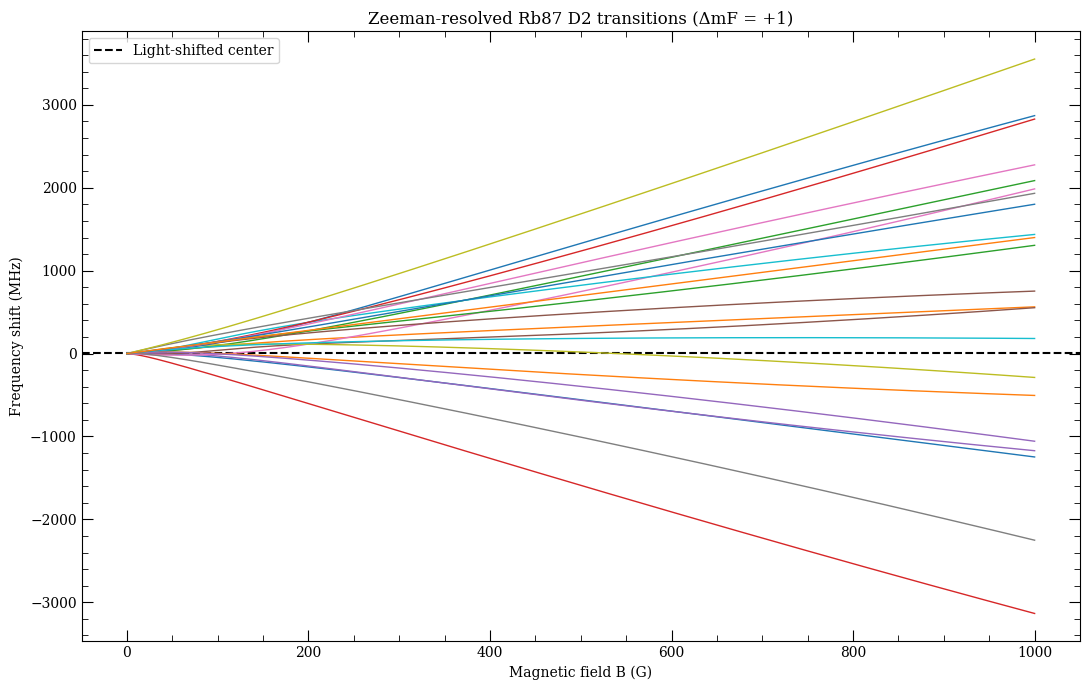

In [151]:
plt.figure(figsize=(11, 7))
plt.axhline(-Rb_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')

x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Rb_transitions.items():

    # --- NEW: keep only ΔmF = +1 transitions ---
    if "ΔmF=+1" not in label:
        continue

    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)


plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.legend()
plt.title("Zeeman-resolved Rb87 D2 transitions (ΔmF = +1)")
plt.tight_layout()
plt.show()

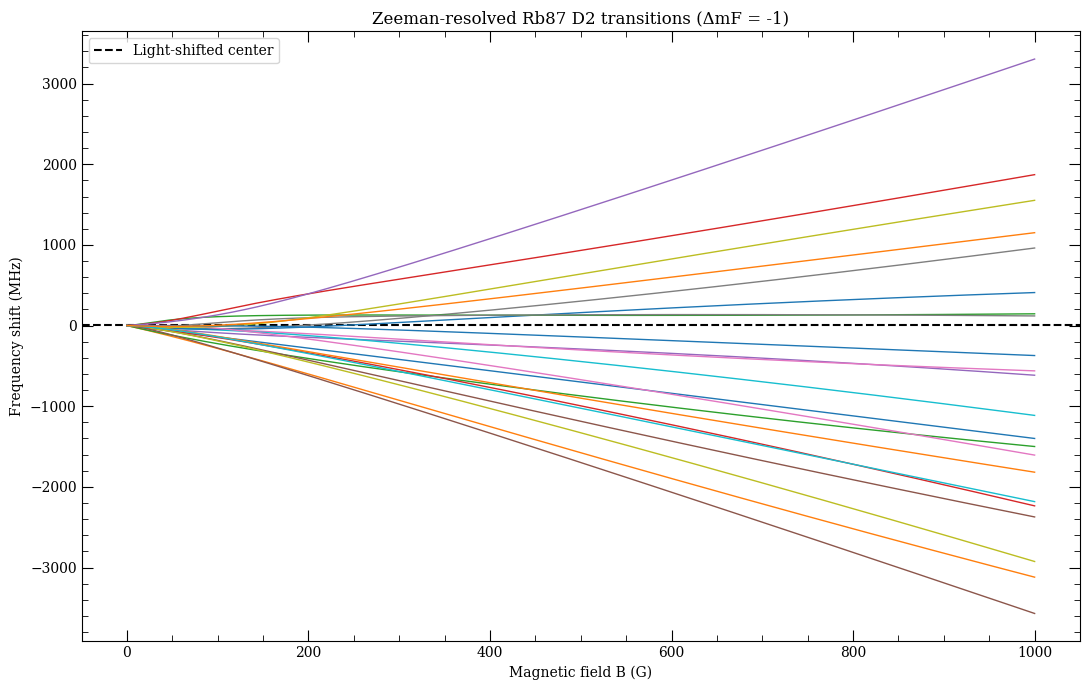

In [152]:
plt.figure(figsize=(11, 7))
plt.axhline(-Rb_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')

x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Rb_transitions.items():

    # --- NEW: keep only ΔmF = +1 transitions ---
    if "ΔmF=-1" not in label:
        continue

    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)


plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.legend()
plt.title("Zeeman-resolved Rb87 D2 transitions (ΔmF = -1)")
plt.tight_layout()
plt.show()

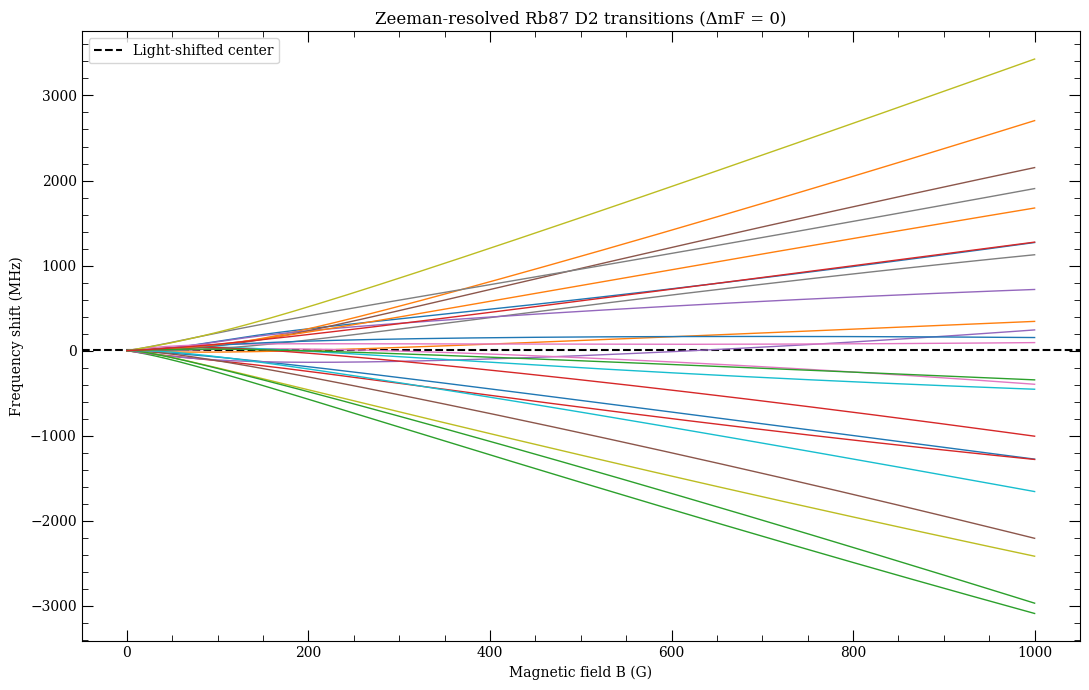

In [153]:
plt.figure(figsize=(11, 7))
plt.axhline(-Rb_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')

x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Rb_transitions.items():

    # --- NEW: keep only ΔmF = +1 transitions ---
    if "ΔmF=+0" not in label:
        continue

    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)


plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.legend()
plt.title("Zeeman-resolved Rb87 D2 transitions (ΔmF = 0)")
plt.tight_layout()
plt.show()

In [154]:
# Build state dicts for e.g. Cs D2: 6S1/2 -> 6P3/2
atom = arc.Caesium()
I = atom.I
gI = atom.gI

# Lower: 6S1/2
n_g, L_g, S_g, J_g = 6, 0, 1/2, 1/2
A_g, B_g = atom.getHFSCoefficients(n=n_g, l=L_g, j=J_g)
gJ_g = lande_gJ(L_g, S_g, J_g, gL=atom.gL, gS=atom.gS)

# Upper: 6P3/2
n_e, L_e, S_e, J_e = 6, 1, 1/2, 3/2
A_e, B_e = atom.getHFSCoefficients(n=n_e, l=L_e, j=J_e)
gJ_e = lande_gJ(L_e, S_e, J_e, gL=atom.gL, gS=atom.gS)

lower = dict(I=I, J=J_g, A_hz=A_g, B_hz=B_g, gJ=gJ_g, gI=gI)
upper = dict(I=I, J=J_e, A_hz=A_e, B_hz=B_e, gJ=gJ_e, gI=gI)

B_fields = np.linspace(0.0000001, 0.1, 501)  # Tesla
# Compute transitions (you can still compute all ΔmF if you want)
Bs, Cs_transitions = zeeman_transition_frequencies_by_mF(
    lower, upper, B_fields,
    allowed_delta_mF=(0, +1, -1), require_B0_in_grid=False   # keep general
)

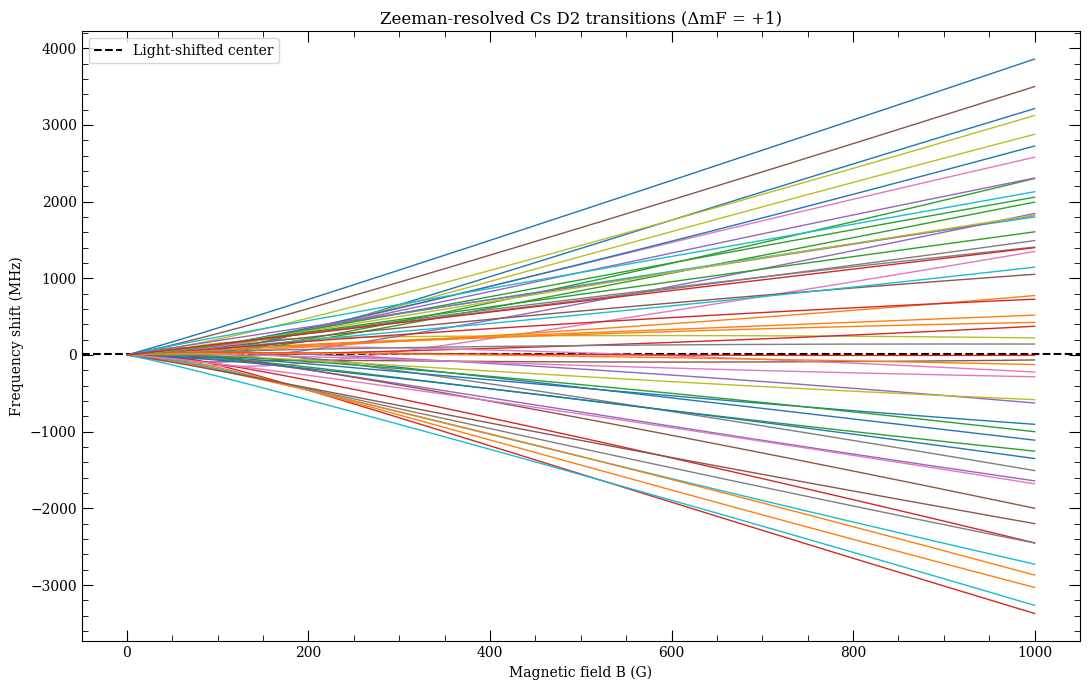

In [155]:
plt.figure(figsize=(11, 7))
plt.axhline(-Cs_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')
x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Cs_transitions.items():

    # --- NEW: keep only ΔmF = +1 transitions ---
    if "ΔmF=+1" not in label:
        continue

    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)


plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.title("Zeeman-resolved Cs D2 transitions (ΔmF = +1)")
plt.tight_layout()
plt.legend()
plt.show()

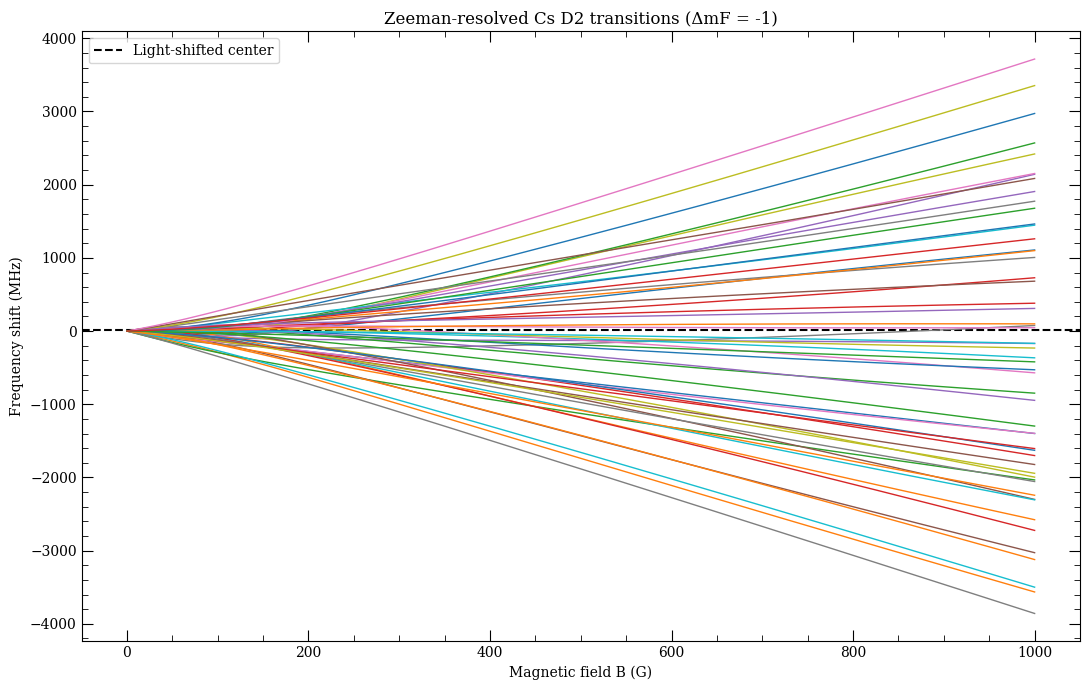

In [156]:
plt.figure(figsize=(11, 7))
plt.axhline(-Cs_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')
x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Cs_transitions.items():

    # --- NEW: keep only ΔmF = +1 transitions ---
    if "ΔmF=-1" not in label:
        continue

    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)


plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.legend()
plt.title("Zeeman-resolved Cs D2 transitions (ΔmF = -1)")
plt.tight_layout()
plt.show()

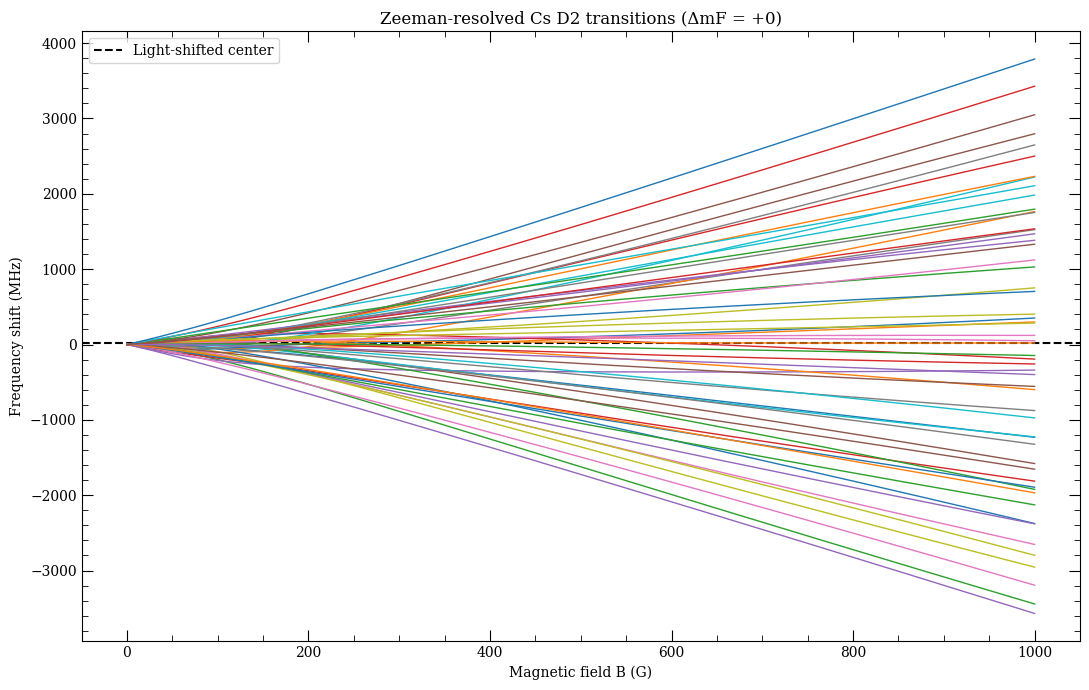

In [157]:
plt.figure(figsize=(11, 7))
plt.axhline(-Cs_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')
x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Cs_transitions.items():

    # --- NEW: keep only ΔmF = +1 transitions ---
    if "ΔmF=+0" not in label:
        continue

    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)


plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.legend()
plt.title("Zeeman-resolved Cs D2 transitions (ΔmF = +0)")
plt.tight_layout()
plt.show()

# MOT Doppler Broadening

In [132]:
def find_dopp_linewidth(lamb, temp, mass):
    return (2*np.sqrt(2*np.log(2))/lamb)*np.sqrt(kB*temp/mass)

def find_first_B(
    Bs,
    transitions,
    shift_low_hz,
    shift_high_hz,
    transitions_are_absolute=True,
    use_absolute_value=True
):
    """
    Return the first B such that NO transition shift lies in [shift_low_hz, shift_high_hz].

    Parameters
    ----------
    Bs : ndarray
        Magnetic field array (Tesla), shape (nB,)
    transitions : dict
        label -> ndarray of transition frequencies vs B (Hz)
    shift_low_hz : float
        Lower bound of forbidden shift window (Hz). Must be >= 0 if use_absolute_value=True.
    shift_high_hz : float
        Upper bound of forbidden shift window (Hz). Must be >= shift_low_hz.
    transitions_are_absolute : bool
        If True, transitions[label] is ν(B) and Δν(B)=ν(B)-ν(0).
        If False, transitions[label] is already Δν(B).
    use_absolute_value : bool
        If True, window applies to |Δν|. If False, window applies to signed Δν.

    Returns
    -------
    B_crit : float or None
        First B (Tesla) where the forbidden window contains no transitions.
        None if never achieved over Bs.
    """

    if shift_high_hz < shift_low_hz:
        raise ValueError("shift_high_hz must be >= shift_low_hz")

    labels = list(transitions.keys())
    nu = np.array([transitions[k] for k in labels])  # (n_trans, nB)

    # Convert ν(B) -> Δν(B) if needed
    if transitions_are_absolute:
        nu = nu - nu[:, [0]]

    # Apply abs if desired
    shifts = np.abs(nu) if use_absolute_value else nu

    # Check if ANY shift is inside the window at each B
    in_window = (shifts >= shift_low_hz) & (shifts <= shift_high_hz)  # (n_trans, nB)
    any_in_window = np.any(in_window, axis=0)  # (nB,)

    # We want first B where none are in the window
    idx = np.where(~any_in_window)[0]
    if len(idx) == 0:
        print("No B in the supplied range clears the forbidden shift window.")
        return None

    B_crit = Bs[idx[0]]*1e4
    print(
        f"First B with NO transitions in [{shift_low_hz:.3e}, {shift_high_hz:.3e}] Hz "
        f"({'|Δν|' if use_absolute_value else 'Δν'}): "
        f"B = {B_crit:.2f} G"
    )
    return B_crit

In [ ]:
Rb_mass = 86.909
u_to_kg = 1.66054e-27
# Find where we exceed D2 linewidth
print(f"Bare Rb D2 linewidth (MHz) = {Rb_D2_gamma/1e6}")
print(f"Just doppler broadening from MOT at {Rb_MOT_temperature*1e6} uK (MHz) = {find_dopp_linewidth(Rb_D2_wavelength, Rb_MOT_temperature, Rb_mass*u_to_kg)/1e6}")
print(f"Light shift of tweezered-D2 rel. to free space (MHz) = {Rb_D2freq_shift/1e6}")
print("Because Doppler linewidth << bare linewidth, we just use the bare linewidth")

print("")
print("B necessary to shift more than 1 linewidth away from tweezer light-shifted D2")
Rb_B_crit_linewidth = find_first_B(
    Bs,
    Rb_transitions,
    -Rb_D2freq_shift-Rb_D2_gamma,
    -Rb_D2freq_shift+Rb_D2_gamma,
    transitions_are_absolute=True
)

print("")
print("B necessary to shift more than 2 linewidths away from tweezer light-shifted D2")
Rb_B_crit_twolinewidth = find_first_B(
    Bs,
    Rb_transitions,
    -Rb_D2freq_shift-Rb_D2_gamma*2,
    -Rb_D2freq_shift+Rb_D2_gamma*2,
    transitions_are_absolute=True
)


Bare Rb D2 linewidth (MHz) = 6.065
Just doppler broadening from MOT at 50.0 uK (MHz) = 0.2087365185718691
Light shift of tweezered-D2 rel. to free space (MHz) = -3.3689013439596227
Because Doppler linewidth << bare linewidth, we just use the bare linewidth

B necessary to shift more than 1 linewidth away from tweezer light-shifted D2
First B with NO transitions in [-2.696e+06, 9.434e+06] Hz (|Δν|): B = 314.00 G

B necessary to shift more than 2 linewidths away from tweezer light-shifted D2
First B with NO transitions in [-8.761e+06, 1.550e+07] Hz (|Δν|): B = 333.00 G


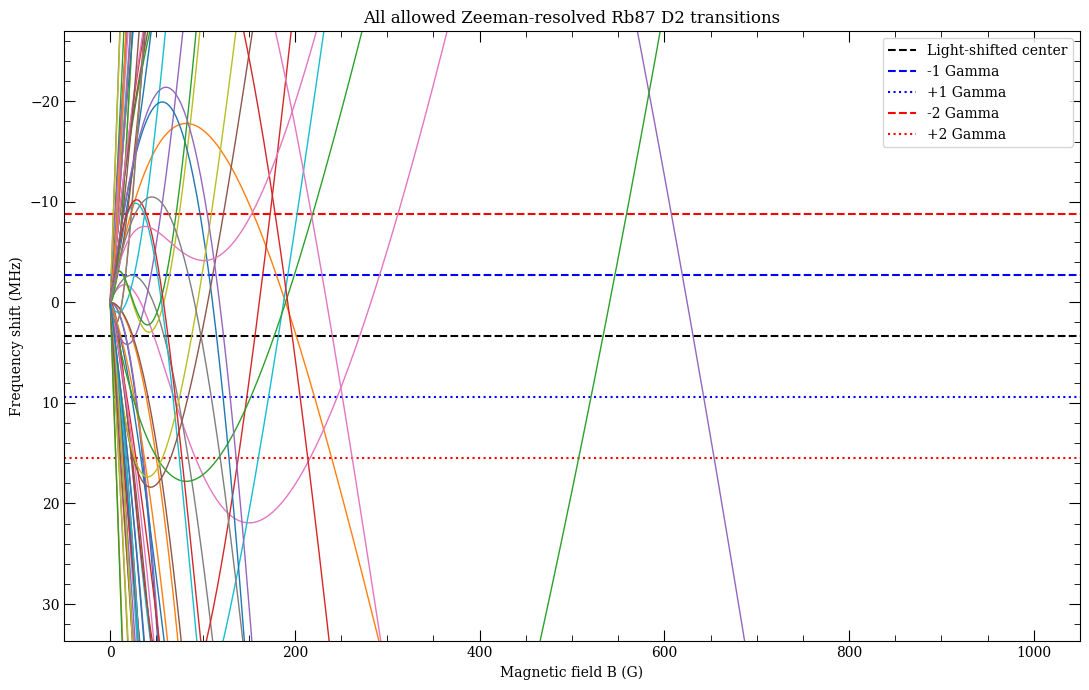

In [164]:
plt.figure(figsize=(11, 7))
plt.axhline(-Rb_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')
plt.axhline((-Rb_D2freq_shift-Rb_D2_gamma)/1e6, color='blue', linestyle='dashed', label='-1 Gamma')
plt.axhline((-Rb_D2freq_shift+Rb_D2_gamma)/1e6, color='blue', linestyle='dotted', label='+1 Gamma')
plt.axhline((-Rb_D2freq_shift-2*Rb_D2_gamma)/1e6, color='red', linestyle='dashed', label='-2 Gamma')
plt.axhline((-Rb_D2freq_shift+2*Rb_D2_gamma)/1e6, color='red', linestyle='dotted', label='+2 Gamma')

x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Rb_transitions.items():
    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)

plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.ylim([(-Rb_D2freq_shift+5*Rb_D2_gamma)/1e6,(-Rb_D2freq_shift-5*Rb_D2_gamma)/1e6])
plt.legend()
plt.title("All allowed Zeeman-resolved Rb87 D2 transitions")
plt.tight_layout()
plt.show()

In [165]:
Cs_mass = 132.905
u_to_kg = 1.66054e-27
# Find where we exceed D2 linewidth
print(f"Bare Cs D2 linewidth (MHz) = {Cs_D2_gamma/1e6}")
print(f"Just doppler broadening from MOT at {Cs_MOT_temperature*1e6} uK (MHz) = {find_dopp_linewidth(Cs_D2_wavelength, Cs_MOT_temperature, Cs_mass*u_to_kg)/1e6}")
print(f"Light shift of tweezered-D2 rel. to free space (MHz) = {Cs_D2freq_shift/1e6}")
print("Because Doppler linewidth << bare linewidth, we just use the bare linewidth")


print("")
print("B necessary to shift more than 1 linewidth away from tweezer light-shifted D2")
Cs_B_crit_linewidth = find_first_B(
    Bs,
    Cs_transitions,
    -Cs_D2freq_shift - Cs_D2_gamma,
    -Cs_D2freq_shift + Cs_D2_gamma,
    transitions_are_absolute=True
)

print("")
print("B necessary to shift more than 2 linewidths away from tweezer light-shifted D2")
Cs_B_crit_twolinewidth = find_first_B(
    Bs,
    Cs_transitions,
    -Cs_D2freq_shift - 2*Cs_D2_gamma,
    -Cs_D2freq_shift + 2*Cs_D2_gamma,
    transitions_are_absolute=True
)


Bare Cs D2 linewidth (MHz) = 5.2227
Just doppler broadening from MOT at 50.0 uK (MHz) = 0.1545156450978261
Light shift of tweezered-D2 rel. to free space (MHz) = -15.80825221701667
Because Doppler linewidth << bare linewidth, we just use the bare linewidth

B necessary to shift more than 1 linewidth away from tweezer light-shifted D2
First B with NO transitions in [1.059e+07, 2.103e+07] Hz (|Δν|): B = 0.00 G

B necessary to shift more than 2 linewidths away from tweezer light-shifted D2
First B with NO transitions in [5.363e+06, 2.625e+07] Hz (|Δν|): B = 0.00 G


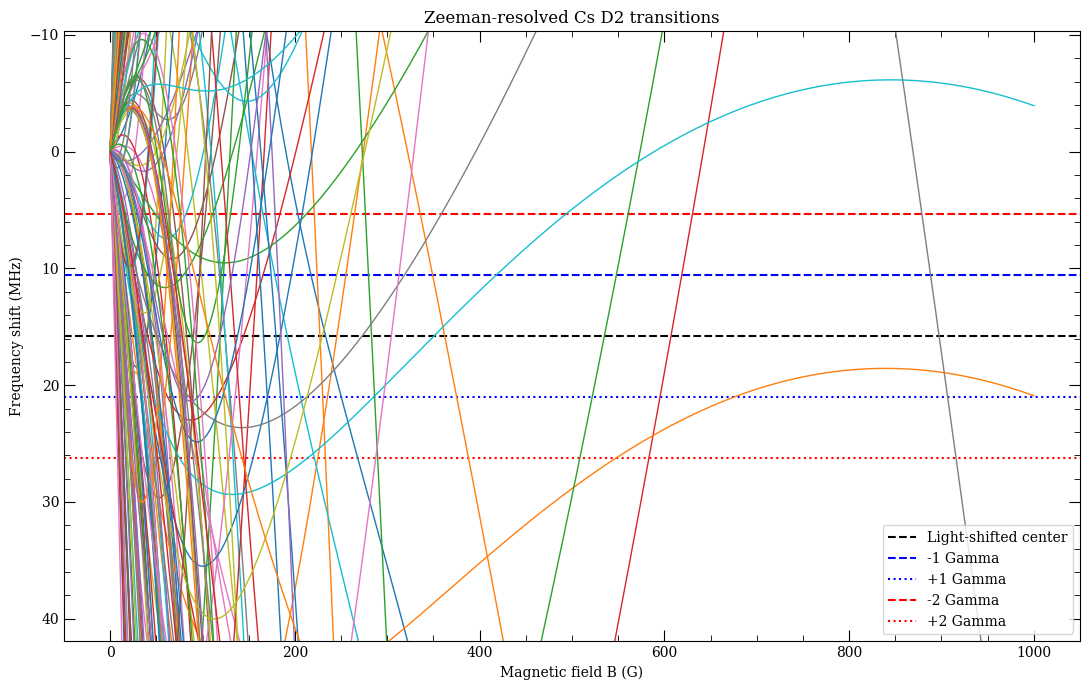

In [162]:
plt.figure(figsize=(11, 7))
plt.axhline(-Cs_D2freq_shift/1e6, color='black', linestyle='dashed', label='Light-shifted center')
plt.axhline((-Cs_D2freq_shift-Cs_D2_gamma)/1e6, color='blue', linestyle='dashed', label='-1 Gamma')
plt.axhline((-Cs_D2freq_shift+Cs_D2_gamma)/1e6, color='blue', linestyle='dotted', label='+1 Gamma')
plt.axhline((-Cs_D2freq_shift-2*Cs_D2_gamma)/1e6, color='red', linestyle='dashed', label='-2 Gamma')
plt.axhline((-Cs_D2freq_shift+2*Cs_D2_gamma)/1e6, color='red', linestyle='dotted', label='+2 Gamma')

x = Bs * 1e4        # Tesla -> Gauss

for label, nu_B in Cs_transitions.items():
    y = nu_B / 1e6  # Hz -> MHz
    plt.plot(x, y, lw=1)

plt.xlabel("Magnetic field B (G)")
plt.ylabel("Frequency shift (MHz)")
plt.ylim([(-Cs_D2freq_shift+5*Cs_D2_gamma)/1e6,(-Cs_D2freq_shift-5*Cs_D2_gamma)/1e6])
plt.legend()
plt.title("Zeeman-resolved Cs D2 transitions")
plt.tight_layout()
plt.show()